<a href="https://colab.research.google.com/github/clemencia/ML4PPGF_UERJ/blob/master/XGB_simple_Classfier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Usando a biblioteca Extreme gradient boosting

Para o mesmo exemplo das "luas"

XGBoost https://github.com/dmlc/xgboost




In [0]:
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

%matplotlib inline

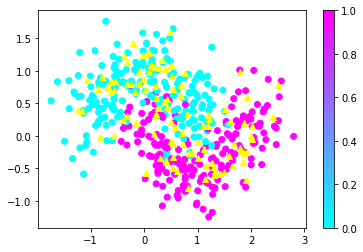

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

plt.scatter(X_train[:,0],X_train[:,1],c=y_train,cmap="cool")
plt.colorbar()
plt.scatter(X_test[:,0],X_test[:,1],color="yellow", marker="^")


#### Formatar os dados:
Para usar o  XGBoost os dados precisam estar num  formato específico. Isto é um objeto tipo DMatrix que sera usado para treinar o modelo BDT.

Os dados já estavam separados em treinamento e teste.



In [0]:
feature_names = ["X1","X2"]  # we skip last  column because it's the label
train = xgb.DMatrix(X_train,label=y_train,
                    missing=-999.0,feature_names=feature_names)
test = xgb.DMatrix(data=X_test,label=y_test,
                   missing=-999.0,feature_names=feature_names)

In [4]:
print('Number of training samples: {}'.format(train.num_row()))
print('Number of testing samples: {}'.format(test.num_row()))


Number of training samples: 400
Number of testing samples: 100


Logo precisamos definis os hyperparámetros para chamar o booster: a "taxa de aprendizado", a profundidade máxima de cada arvore do bdt, tamanho da subamostra,  fração das variáveis a usar (como só temos 2, temos que usar ambas).

A opção de função objetiva é que define o tipo de BDT (classificação ou regressão) e o tipo de output. Nesse caso :

 ```objective = binary:logistic``` 

 é o classificador binario de regressão logística, onde o output é uma probabilidade.

Outras opções : https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters




In [5]:
param = []

# Boost5er parameters
param+= [('eta',        0.1)]               # learning rate
param+= [('max_depth',    1)]               # maximum depth of a tree
param+= [('subsample',  0.8)]               # fraction of events to train tree on
param+= [('colsample_bytree',1)]          # fraction of features to train tree on
# Learning task parameters
param+= [('objective', 'binary:logistic')]   # objective function
param+= [('eval_metric', 'error')]           # evaluation metric for cross validation
param+= [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]
print(param)
num_trees = 150  # number of trees to make

[('eta', 0.1), ('max_depth', 1), ('subsample', 0.8), ('colsample_bytree', 1), ('objective', 'binary:logistic'), ('eval_metric', 'error'), ('eval_metric', 'logloss'), ('eval_metric', 'rmse')]


Agora podemos treinar o algoritmo BDT

In [0]:
booster = xgb.train(param,train,num_boost_round=num_trees)

Podemos imprimir o resultado das métricas de avaliação



In [7]:
print(booster.eval(test))

[0]	eval-error:0.090000	eval-logloss:0.241044	eval-rmse:0.272148


In [0]:
predictions = booster.predict(test)

E graficar as predições sobre o subconjunto de teste


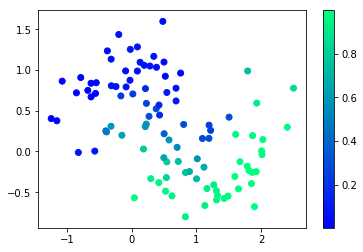

In [9]:
plt.scatter(X_test[:,0],X_test[:,1],c=predictions, cmap="winter")
plt.colorbar()

Como este algoritmo entrega uma variável output (que podemos interpretar como probabilidade), podemos pensar em valores de corte para esta variável e avaliar eficiência e pureza para cada corte

corte em 0.0 --> eficiência  100.0 % e  pureza 57.0 %
corte em 0.1 --> eficiência  100.0 % e  pureza 86.4 %
corte em 0.2 --> eficiência  98.2 % e  pureza 90.3 %
corte em 0.3 --> eficiência  91.2 % e  pureza 96.3 %
corte em 0.4 --> eficiência  86.0 % e  pureza 100.0 %
corte em 0.5 --> eficiência  84.2 % e  pureza 100.0 %
corte em 0.6 --> eficiência  73.7 % e  pureza 100.0 %
corte em 0.7 --> eficiência  66.7 % e  pureza 100.0 %
corte em 0.8 --> eficiência  56.1 % e  pureza 100.0 %
corte em 0.9 --> eficiência  52.6 % e  pureza 100.0 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


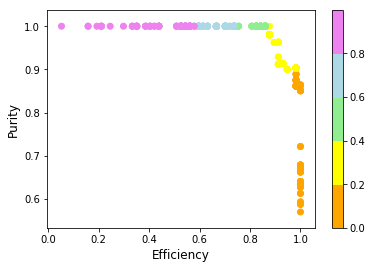

In [10]:
from matplotlib.colors import ListedColormap
def plotROC(predictions,y_test):
    # choose score cuts:
    cuts = np.linspace(0,1,500);
    n_truePos = np.zeros(len(cuts));
    n_falsePos = np.zeros(len(cuts));
    n_TotPos = len(np.where(y_test==1)[0])
    for i,cut in enumerate(cuts):
       n_truePos[i] = len(np.where(predictions[y_test==1] > cut)[0]);
       n_falsePos[i] = len(np.where(predictions[y_test==0] > cut)[0]);
       if i%50 ==0:
         print("corte em {:2.1f} --> eficiência  {:2.1f} % e  pureza {:2.1f} %".format(cut,n_truePos[i]/n_TotPos *100,n_truePos[i]/(n_truePos[i]+n_falsePos[i])*100))
         
    # plot efficiency vs. purity (ROC curve)
    plt.figure();

    custom_cmap3 = ListedColormap(['orange','yellow','lightgreen',"lightblue","violet"])
    plt.scatter((n_truePos/n_TotPos),n_truePos/(n_truePos + n_falsePos),c=cuts,cmap=custom_cmap3,label="ROC");
    # make the plot readable
    plt.xlabel('Efficiency',fontsize=12);
    plt.ylabel('Purity',fontsize=12);
    plt.colorbar()

plotROC(predictions,y_test)

Nesse caso, pore exemplo, o valor de corte 0.4 ainda tem uma eficiência >80% e já atinge uma pureza de 100% (no subconjunto de teste o que pode ser uma sobreestimação, ver histogramas mais abaixo)

In [0]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.4, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    data_xnew = xgb.DMatrix(data=X_new,
                    missing=-999.0,feature_names=("X1","X2"))
    y_pred_temp = clf.predict(data_xnew).reshape(x1.shape)
    y_pred = np.array([i>0.4 for i in y_pred_temp ])
    custom_cmap = ListedColormap(['orange','green','yellow'])
    plt.contourf(x1, x2, y_pred, alpha=0.9, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['violet','purple'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "ro", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)


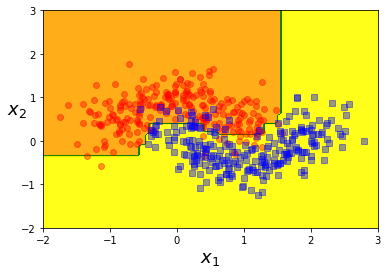

In [12]:
plot_decision_boundary(booster,X,y,axes=[-2,3,-2,3],contour=False)
#plt.colorbar()

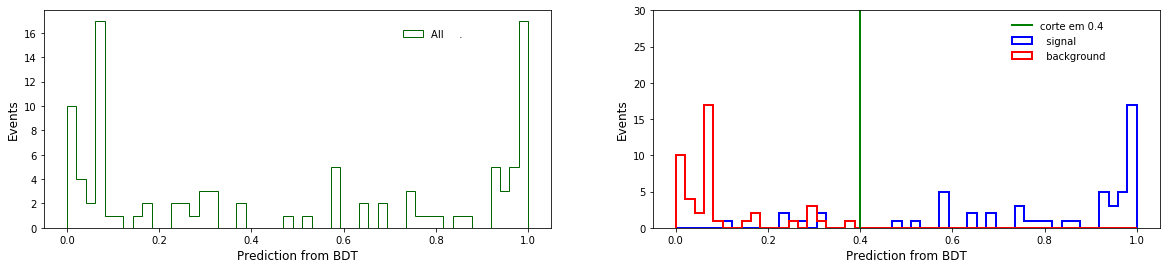

In [13]:
def plotBDTOutputHist(predictions,test,cutval=0.4,y_lim=30):
    plt.figure(figsize=(20,4))
    plt.subplot(121)
    plt.hist(predictions,bins=np.linspace(0,1,50),histtype='step',color='darkgreen',label='All     .')
    # make the plot readable
    plt.xlabel('Prediction from BDT',fontsize=12)
    plt.ylabel('Events',fontsize=12)
    plt.legend(frameon=False,loc=(0.7,0.85))

    # plot signal and background separately
    plt.subplot(122)
    plt.hist(predictions[test.get_label().astype(bool)],bins=np.linspace(0,1,50),
         histtype='step',color='blue',linewidth=2,label='  signal')
    plt.hist(predictions[~(test.get_label().astype(bool))],bins=np.linspace(0,1,50),
         histtype='step',color='red',linewidth=2,label='  background')
    # make the plot readable
    plt.plot([cutval,cutval],[0,y_lim],label="corte em {:2.1f}".format(cutval),color="green",linewidth=2)
    plt.xlabel('Prediction from BDT',fontsize=12)
    plt.ylabel('Events',fontsize=12)
    plt.ylim([0,y_lim])
    plt.legend(frameon=False, loc=(0.7,0.75))

plotBDTOutputHist(predictions,test)

### Avaliando o output do XGBooster no subconjunto de treinamento

Fazemos a mesma curva ROC e histogramas aplicando o BDT na amostra de treinamento, temos uma estimativa mais realista da pureza e eficiência, e da distribuição do "sinal" e "background". Com esta avaliação, o valor de corte poderia ser melhor em 0.5 ou 0.6.

In [0]:
predict_closure= booster.predict(train)

corte em 0.0 --> eficiência  100.0 % e  pureza 48.2 %
corte em 0.1 --> eficiência  99.5 % e  pureza 72.7 %
corte em 0.2 --> eficiência  97.4 % e  pureza 80.7 %
corte em 0.3 --> eficiência  96.9 % e  pureza 87.8 %
corte em 0.4 --> eficiência  94.3 % e  pureza 91.0 %
corte em 0.5 --> eficiência  93.3 % e  pureza 93.8 %
corte em 0.6 --> eficiência  87.6 % e  pureza 96.6 %
corte em 0.7 --> eficiência  83.9 % e  pureza 97.6 %
corte em 0.8 --> eficiência  73.1 % e  pureza 98.6 %
corte em 0.9 --> eficiência  66.8 % e  pureza 100.0 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


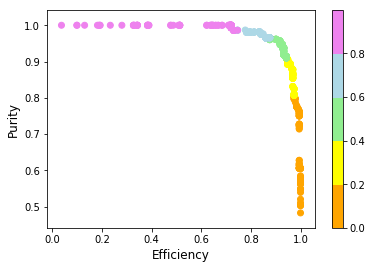

In [15]:
plotROC(predict_closure,y_train)

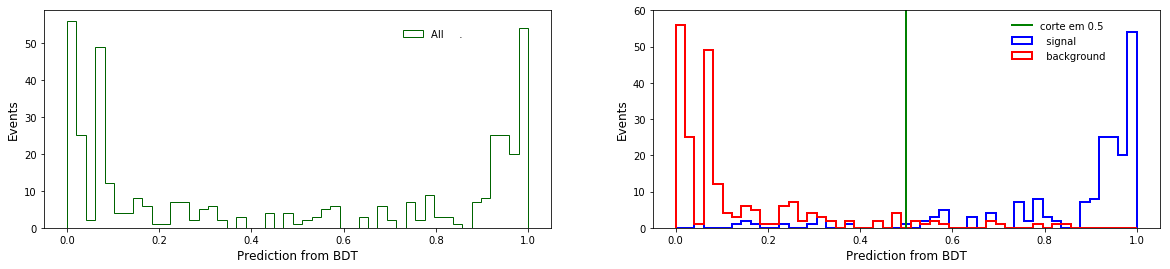

In [16]:
plotBDTOutputHist(predict_closure,train,0.5,60)